* Spearmint for analogy reasoning
* Gaussian LDA
* Evaluate word analogy reasoning
* evalutate topic models
* find background noise
* find word pairs

# Setup

In [163]:
%matplotlib notebook

import itertools
import logging
from functools import partial

import gensim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pnd
from sklearn.cluster import *
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.manifold import TSNE

from knub.thesis.util import *
matplotlib.style.use('ggplot')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
div.text_cell_render p, div.text_cell_render ul, table.dataframe {
font-size:1.3em;
line-height:1.1em;
}
</style>
""")

In [3]:
MODEL = "../models/topic-models/topic.full.alpha-1-100.256-400.model"

# Evaluating strength of raw models

## Topic Models → Topic Coherence, Concept Categorization

Evaluated using Palmetto tool from **Exploring the Space of Topic Coherence Measures** paper
Values still seem low compared to example values from the paper

In [278]:
df_tc_results = pnd.DataFrame([
        ("topic.full.alpha-1-100.256-400.model", 0.469500859375, 0.00617111859067, 0.6463414634146342),
        ("topic.16-400.model", 0.43805875, 0.00390183951094, 0.5975609756097561),
        ("topic.256-1000.model", 0.473455351563, 0.00635883046394, 0.5853658536585366),
        ("topic.64-400.model", 0.45327734375, 0.00385141007263, 0.6341463414634146),
        ("topic.256-400.model", 0.46836359375, 0.00599032492068, 0.5731707317073171),
        ("topic.full.fixed-vocabulary.alpha-1-100.256-400.model", 0.468437070312, 0.00562772603243, 0.5975609756097561),
        ("topic.full.256-400.model", 0.472498945313, 0.00624853749772, 0.5975609756097561),
        ("topic.256-600.model", 0.478640273437, 0.00685787139094, 0.5609756097560975)
    ], 
    columns=["Topic model parameters", "TC_mean", "TC_var", "CC_purity"])

In [275]:
df_tc_results.sort_values(by="TC_mean", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
7,topic.256-600.model,0.478640,0.006858,0.560976
2,topic.256-1000.model,0.473455,0.006359,0.585366
6,topic.full.256-400.model,0.472499,0.006249,0.597561
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
5,topic.full.fixed-vocabulary.alpha-1-100.256-400.model,0.468437,0.005628,0.597561
4,topic.256-400.model,0.468364,0.005990,0.573171
3,topic.64-400.model,0.453277,0.003851,0.634146
1,topic.16-400.model,0.438059,0.003902,0.597561


In [276]:
df_tc_results.sort_values(by="CC_purity", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
3,topic.64-400.model,0.453277,0.003851,0.634146
1,topic.16-400.model,0.438059,0.003902,0.597561
5,topic.full.fixed-vocabulary.alpha-1-100.256-400.model,0.468437,0.005628,0.597561
6,topic.full.256-400.model,0.472499,0.006249,0.597561
2,topic.256-1000.model,0.473455,0.006359,0.585366
4,topic.256-400.model,0.468364,0.005990,0.573171
7,topic.256-600.model,0.478640,0.006858,0.560976


In [277]:
df_tc_results.sort_values(by="TC_var", ascending=False)

,Topic model parameters,TC_mean,TC_var,CC_purity
7,topic.256-600.model,0.478640,0.006858,0.560976
2,topic.256-1000.model,0.473455,0.006359,0.585366
6,topic.full.256-400.model,0.472499,0.006249,0.597561
0,topic.full.alpha-1-100.256-400.model,0.469501,0.006171,0.646341
4,topic.256-400.model,0.468364,0.005990,0.573171
5,topic.full.fixed-vocabulary.alpha-1-100.256-400.model,0.468437,0.005628,0.597561
1,topic.16-400.model,0.438059,0.003902,0.597561
3,topic.64-400.model,0.453277,0.003851,0.634146


## Word Embeddings → Analogy Reasoning

Using the question word data set (~19k questions) from **Efficient Estimation of Word Representations in Vector Space** (word2vec).
Also, currently running Spearmint optimization to look for better embeddings.

In [7]:
pnd.set_option("display.max_colwidth", 100)

In [8]:
df_tc_results = pnd.DataFrame([
        ("embedding.skip-gram.size-200.window-5.negative-5.model", 0.481221858371),
        ("embedding.cbow.size-200.window-5.model", 0.416547277937),
        ("embedding.google.size-300", 0.735878018829),
    ], 
    columns=["Word Embeddings", "Analogy_Reasoning"])

df_tc_results.sort_values(by="Analogy_Reasoning", ascending=False)

,Word Embeddings,Analogy_Reasoning
2,embedding.google.size-300,0.735878
0,embedding.skip-gram.size-200.window-5.negative-5.model,0.481222
1,embedding.cbow.size-200.window-5.model,0.416547


# Preprocessing

## Word Embeddings

In [210]:
SKIP_GRAM_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/embedding.model.skip-gram"
WORD2VEC_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/GoogleNews-vectors-negative300.bin"

vectors = gensim.models.Word2Vec.load_word2vec_format(SKIP_GRAM_VECTOR_FILE, binary=True)
#vectors = gensim.models.Word2Vec.load_word2vec_format(WORD2VEC_VECTOR_FILE, binary=True)b


## Topic Probs

In [177]:
prob_columns = map(str, list(range(256)))
df_probs = pnd.read_csv(MODEL + ".topic-probs-normalized")
df_probs.head(1)

,word,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,telenovela,1.214193e-07,2.223318e-07,9.899904e-08,9.060979e-08,1.013037e-07,1.331774e-07,2.021269e-07,2.997380e-07,1.059199e-07,...,1.128502e-07,1.859248e-07,2.302089e-07,1.160958e-07,1.022787e-07,2.562968e-07,1.769988e-07,7.058314e-08,1.176371e-07,5.748606e-07


## Topics

In [45]:
df_topics = pnd.read_csv(MODEL + ".ssv", sep=" ", encoding="utf-8")
topic_words = set(df_topics.ix[:,-10:].values.flatten())
df_topics.head(10)

,topic,topic-count,0,1,2,3,4,5,6,7,8,9
0,65,23128995,would,time,one,could,said,new,however,first,made,later
1,97,13874562,life,family,years,born,father,later,died,first,became,children
2,104,9413091,century,people,many,land,first,war,became,population,british,early
3,115,9009161,many,often,used,also,century,popular,early,one,term,use
4,11,8577457,one,get,back,like,tells,time,says,day,home,man
5,171,8335966,social,theory,may,one,people,study,human,different,example,also
6,203,8168980,novel,story,book,one,life,wrote,character,love,first,poem
7,205,7893841,war,army,battle,forces,would,men,led,however,sent,troops
8,113,7415581,city,street,area,park,located,town,also,many,one,district
9,209,7410332,film,films,directed,festival,movie,director,released,production,best,documentary


## Similars

In [80]:
def get_similarity(word1, word2, v):
    # ugly but works for now
    if word1 not in v:
        if word1.upper() in v:
            word1 = word1.upper()
        if word1.title() in v:
            word1 = word1.title()
    if word2 not in v:
        if word2.upper() in v:
            word2 = word2.upper()
        if word2.title() in v:
            word2 = word2.title()
    try:
        return v.similarity(word1, word2)
    except KeyError:         
        return -1.0

df_similars = pnd.read_csv(MODEL + ".similars", sep="\t", header=None, encoding="utf-8")
df_similars["tm_sim"] = 1 - df_similars[0]
del df_similars[0] # delete original jensen shannon divergence
del df_similars[1] # delete "SIM" column
df_similars.columns = ["word", "similars", "tm_sim"]
df_similars["we_sim"] = df_similars[["word", "similars"]].apply(
    lambda x: get_similarity(x["word"], x["similars"], vectors), axis=1)
df_similars = df_similars[df_similars["we_sim"] != -1]

# Topic Probs Analysis

## Topic Probs

In [131]:
df_topic_probs = df_probs[df_probs.word.apply(lambda w: w in topic_words)].copy()
df_topic_probs["stddev"] = df_topic_probs[prob_columns].std(axis=1)

In [132]:
df_topic_probs.head(3)[prob_columns].mean(axis=1)*256

1    1.0
2    1.0
5    1.0
dtype: float64

In [94]:
df_topic_probs

,word,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,stddev
1,series,3.402219e-04,1.566579e-09,2.472622e-04,1.832785e-02,7.137995e-10,9.383861e-10,1.170492e-03,9.891894e-04,5.164168e-03,...,3.709805e-03,8.345888e-04,1.485967e-04,1.854687e-03,1.805902e-09,3.881944e-04,1.708691e-03,6.861056e-04,4.050545e-09,0.012731
2,american,6.811750e-04,1.361516e-09,6.062508e-10,1.217159e-03,7.997958e-04,8.155526e-10,1.237786e-09,7.681465e-03,1.224109e-03,...,2.700992e-03,1.409754e-09,7.109482e-10,6.949485e-04,1.569512e-09,1.083906e-09,9.540832e-04,2.245124e-03,3.520334e-09,0.008736
5,television,2.099360e-09,3.844152e-09,1.711710e-09,1.292190e-04,1.751558e-09,2.302660e-09,3.494808e-09,7.633594e-05,2.652384e-03,...,3.214671e-09,3.980349e-09,2.007316e-09,6.719913e-04,4.431414e-09,3.060338e-09,1.220394e-09,2.033966e-09,9.939434e-09,0.020420
14,spanish,2.828481e-09,5.179251e-09,2.306197e-09,2.134762e-04,7.340802e-03,3.102388e-09,4.708577e-09,1.420576e-02,2.467420e-09,...,1.220545e-03,3.580720e-04,2.704470e-09,2.382596e-09,2.952896e-02,4.123213e-09,1.644245e-09,6.727211e-05,1.339146e-08,0.030737
16,opera,7.247795e-09,1.327149e-08,5.909477e-09,5.408704e-09,6.047048e-09,7.949663e-09,1.206542e-08,1.789204e-08,6.322600e-09,...,1.109827e-08,1.374169e-08,6.930024e-09,6.105245e-09,1.529894e-08,1.056546e-08,4.213268e-09,7.022028e-09,3.431473e-08,0.034622
18,miami,8.997483e-09,1.647535e-08,7.336082e-09,6.714418e-09,7.506863e-09,9.868789e-09,1.497812e-08,6.080443e-01,3.244602e-03,...,1.377750e-08,1.705907e-08,8.602999e-09,4.831302e-02,1.899225e-08,1.311606e-08,5.230391e-09,8.717214e-09,4.259864e-08,0.038471
19,florida,2.654060e-09,4.859868e-09,2.163983e-09,1.980606e-09,2.214360e-09,2.911076e-09,4.418218e-09,8.008206e-01,6.365636e-05,...,4.064062e-09,5.032051e-09,2.537696e-09,7.885184e-03,5.602297e-09,3.868951e-09,1.542851e-09,4.822481e-04,1.256567e-08,0.050056
21,daily,2.188836e-03,1.176329e-08,5.237911e-09,4.424888e-04,6.257518e-03,7.046245e-09,1.069428e-08,1.585875e-08,5.604086e-09,...,9.837041e-09,1.218005e-08,6.142481e-09,5.411431e-09,2.569788e-03,3.273528e-03,2.508143e-03,3.667448e-05,8.720502e-03,0.022059
22,life,1.411053e-04,2.288168e-09,1.018867e-09,2.594950e-03,2.579773e-04,1.370620e-09,2.080227e-09,3.937698e-04,4.026711e-03,...,7.440251e-04,2.824197e-03,1.022440e-02,6.925009e-05,1.787115e-04,5.797001e-03,7.264194e-10,2.960053e-04,5.916284e-09,0.008422
23,star,1.600250e-03,6.573205e-09,2.926892e-09,1.045839e-02,6.558058e-04,3.937371e-09,3.080544e-03,8.861708e-09,8.489601e-03,...,2.914623e-04,6.806091e-09,3.432356e-09,3.034446e-03,9.084527e-03,5.232942e-09,2.086780e-09,3.477925e-09,1.699567e-08,0.016079


### Highest std. dev.

In [95]:
df_topic_probs.sort_values(by="stddev", ascending=False).head(10)[["word", "stddev"]]

,word,stddev
97299,gmina,0.062500
15107,cerambycidae,0.062500
5051,forewings,0.062341
12297,rabbi,0.061799
5040,moth,0.061736
26868,nascar,0.061622
12185,nigerian,0.061617
97298,voivodeship,0.061585
29709,kuala,0.061550
30707,nhl,0.061477


### Lowest std. dev.

In [96]:
df_topic_probs.sort_values(by="stddev", ascending=True).head(10)[["word", "stddev"]]

,word,stddev
169,one,0.002358
188,also,0.002516
302,two,0.002998
430,first,0.003318
354,known,0.003707
483,time,0.004129
680,part,0.004133
412,later,0.004259
2844,however,0.004622
2167,early,0.004699


## Correlation TM similarity and WE similarity

### Ten most similar words for each top-10-topic word

 Topic model similarity evaluated using [Jensen-Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) on the normalized word-topic distributions

In [97]:
df_similars

,word,similars,tm_sim,we_sim
0,military,army,0.881573,0.608158
1,military,civilian,0.880264,0.687911
2,military,forces,0.866669,0.571750
3,military,armed,0.858110,0.470527
4,military,commander,0.833280,0.443030
5,military,commanders,0.829955,0.564292
6,military,non-military,0.820832,0.643097
7,military,war,0.817530,0.287915
8,military,army’s,0.813031,0.566314
9,military,stationed,0.807877,0.391147


### Correlation between TM and WE similarity

In [121]:
df_similars[["tm_sim", "we_sim"]].corr("pearson")

,tm_sim,we_sim
tm_sim,1.000000,0.329467
we_sim,0.329467,1.000000


In [130]:
df_similars[["tm_sim", "we_sim"]].corr("spearman")

,tm_sim,we_sim
tm_sim,1.000000,0.331737
we_sim,0.331737,1.000000


**Note: Similar results Google vectors**

### Distribution of TM similarity

<IPython.core.display.Javascript object>


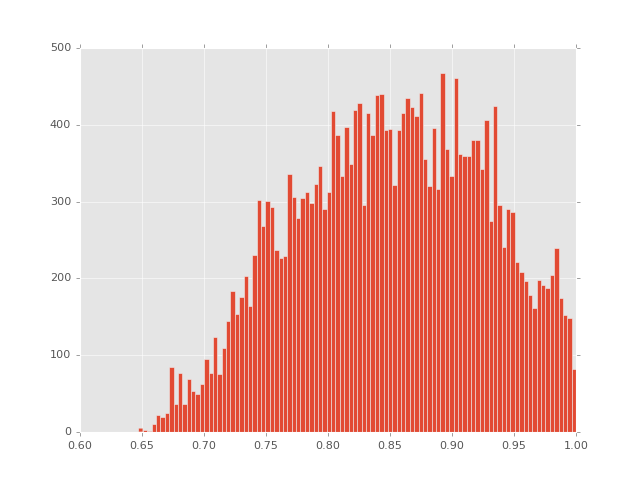

In [133]:
plt.figure()
df_similars["tm_sim"].hist(bins=100)

### Distribution of WE similarity

<IPython.core.display.Javascript object>


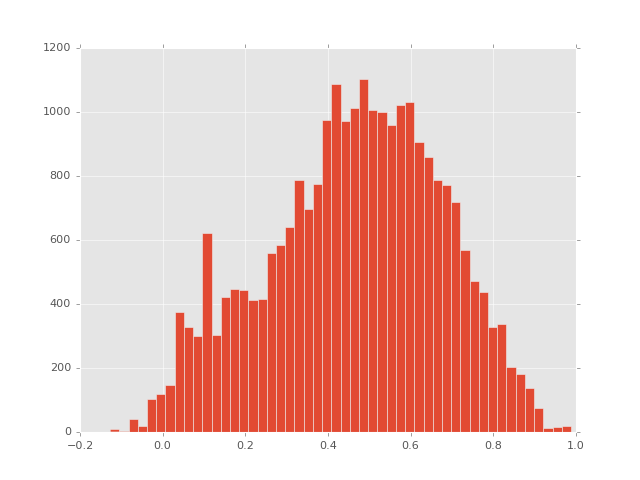

In [124]:
plt.figure()
df_similars["we_sim"].hist(bins=50)

In [125]:
we_percentile = df_similars["we_sim"].quantile(q=.30)
we_percentile

0.36030212788618599

In [126]:
df_tmp = df_topic_probs[["word", "stddev"]]
df_tmp.columns = ["w", "stddev"]
df_result = df_similars.merge(df_tmp, left_on="similars", right_on="w")
del df_result["w"]
word_prob_quantile = df_result["stddev"].quantile(0.8)

### High TM similarity, low WE similarity

In [127]:
df_large_sim_diff = df_result[(df_result["we_sim"] < 0.4) & (df_result["stddev"] > 0.025)]
df_large_sim_diff.iloc[np.random.permutation(len(df_large_sim_diff))]

,word,similars,tm_sim,we_sim,stddev
1329,population,village,0.776748,0.357728,0.033952
2378,families,income,0.727661,0.218131,0.033123
3971,gold,competed,0.649310,0.203620,0.027385
2331,males,median,0.878753,0.381284,0.041268
3109,stage,theatre,0.746388,0.359557,0.036367
3540,dog,zoo,0.904168,0.344741,0.052409
2325,males,median,0.878753,0.381284,0.041268
1399,district,census,0.672897,0.144806,0.025865
3376,province,provincial,0.689083,0.373396,0.025065
4422,list,refer,0.862250,0.062509,0.057045


### High TM similarity, high WE similarity

In [128]:
df_small_sim_diff = df_result[(df_result["we_sim"] > 0.8) & (df_result["stddev"] > 0.025)]
df_small_sim_diff.iloc[np.random.permutation(len(df_small_sim_diff))]

,word,similars,tm_sim,we_sim,stddev
2800,singapore,malaysia,0.961242,0.834527,0.053187
3693,diego,francisco,0.937334,0.921034,0.034502
4273,harris,taylor,0.899821,0.812516,0.025271
4404,gastropod,mollusk,0.999020,0.822415,0.058763
4314,serbian,croatian,0.993638,0.899714,0.061076
4276,taylor,jones,0.902417,0.853006,0.034807
2473,elections,election,0.928577,0.889273,0.032147
3092,norway,denmark,0.964743,0.857881,0.044176
3739,movie,film,0.923200,0.835096,0.031136
2168,missile,missiles,0.982285,0.871936,0.053340


# Findings

* syntatic variations play a bigger role in WE models, example:

  **(development, developed)**: TM-sim: 0.960519 WE-SIM: 0.360895
  
  **(composed, composers)** TM-SIM: 0.973376 WE-SIM: 0.329483
  
  **(works, working)** TM-SIM: 0.969470 WE-SIM: 0.274090
* topic models are better at capturing loose relationships, such as:

  **(war, commander)** TM-SIM: 0.922352 WE-SIM: 0.187498
  
  **(living, households)** TM-SIM: 0.983162 WE-SIM: 0.207906
  
  **(county, rural)** TM-SIM: 0.882099 WE-SIM: 0.257984
  

# Concept categorization in TM and WE

Roughly the same results after using the same algorithm for both systems

In [234]:
def get_embedding_from_word_embedding(word):
    try:
        return vectors[word]
    except:
        return vectors["this"]

columns = [str(i) for i in range(256)]
def get_embedding_from_topics(word):
    df_row = df_probs[df_probs["word"] == word]
    assert len(df_row) == 1, "not exactly one row found: " + word + " " + len(df_row)
    return df_row[columns].iloc[0,:].tolist()

def get_df_concept(embedding_function):
    df_concept = pnd.read_csv(
        "/home/knub/Repositories/master-thesis/data/concept-categorization/battig_concept-categorization.tsv",
        sep="\t",
        header=None)
    df_concept.columns = ["word", "concept"]
    df_concept["embeddings"] = df_concept["word"].apply(embedding_function)
    return df_concept

df_we_concept = get_df_concept(get_embedding_from_word_embedding)
df_tm_concept = get_df_concept(get_embedding_from_topics)
df_tm_concept.head(2)

,word,concept,embeddings
0,dog,land-mammals,"[0.00352872698013, 2.17180189723e-08, 9.67051718033e-09, 0.0028940554259, 9.89564258889e-09, 0.0..."
1,elephant,land-mammals,"[4.18416122346e-08, 7.66164594561e-08, 0.000469006248609, 3.12245165676e-08, 3.4909680306e-08, 4..."


In [235]:
len(df_tm_concept.ix[0,"embeddings"])

256

In [236]:
from sklearn import metrics

# http://stats.stackexchange.com/questions/95731/how-to-calculate-purity
def single_cluster_purity(df_param):
    return df_param["concept"].value_counts().max()

def calculate_purity(df_param):
    purity = float(sum([single_cluster_purity(df_cluster_group)
                        for _, df_cluster_group
                        in df_param.groupby("cluster_id")])) / len(df_param)
    return purity


def evaluate_clustering_algorithm(df_param, clustering):
    X = np.array(df_param["embeddings"].tolist())
    X_sim = metrics.pairwise.pairwise_distances(X, metric="cosine")
    # sim or not sim? PCA or not PCA?
    clusters = clustering.fit_predict(pca(X_sim, 10))
    df_param["cluster_id"] = clusters
    return calculate_purity(df_param)

In [237]:
for df_concept in [df_we_concept, df_tm_concept]:
    print "-" * 100
    for clustering in [KMeans(n_clusters=10, init="k-means++", n_jobs=1),
                       AgglomerativeClustering(n_clusters=10, linkage="ward"),
                       AgglomerativeClustering(n_clusters=10, linkage="complete"),
                       AgglomerativeClustering(n_clusters=10, linkage="average"),
                       AffinityPropagation(damping=0.5),
                       AffinityPropagation(damping=0.6),
                       AffinityPropagation(damping=0.7),
                       AffinityPropagation(damping=0.8),
                       AffinityPropagation(damping=0.9),
                   SpectralClustering(n_clusters=3)]:
        print clustering.__class__.__name__
        print evaluate_clustering_algorithm(df_concept, clustering)

----------------------------------------------------------------------------------------------------
KMeans
0.756097560976
AgglomerativeClustering
0.780487804878
AgglomerativeClustering
0.768292682927
AgglomerativeClustering
0.731707317073
AffinityPropagation
0.719512195122
AffinityPropagation
0.719512195122
AffinityPropagation
0.670731707317
AffinityPropagation
0.670731707317
AffinityPropagation
0.707317073171
SpectralClustering
0.353658536585
----------------------------------------------------------------------------------------------------
KMeans
0.743902439024
AgglomerativeClustering
0.768292682927
AgglomerativeClustering
0.780487804878
AgglomerativeClustering
0.743902439024
AffinityPropagation
0.719512195122
AffinityPropagation
0.719512195122
AffinityPropagation
0.719512195122
AffinityPropagation
0.743902439024
AffinityPropagation
0.121951219512
SpectralClustering
0.365853658537


# Word Similarity

## Similarity

In [267]:
def word_similarity(f):
    try:
        df_sim = pnd.read_csv(MODEL + f, sep="\t")
        df_sim["embedding-sim"] = df_sim[["word1", "word2"]].apply(
            lambda x: get_similarity(x["word1"], x["word2"], vectors), axis=1)
        df_sim["comb-sim"] = df_sim[["topic-sim", "embedding-sim"]].apply(
            lambda x: (5 * x["embedding-sim"] + x["topic-sim"]) / 6,
            axis=1)
        
        topic_corr     = df_sim[["human-sim", "topic-sim"]].corr("spearman").ix[0,1]
        embedding_corr = df_sim[["human-sim", "embedding-sim"]].corr("spearman").ix[0, 1]
        
        topic_corr_pearson  = df_sim[["human-sim", "topic-sim"]].corr("pearson").ix[0,1]
        embedding_corr_pearson = df_sim[["human-sim", "embedding-sim"]].corr("pearson").ix[0, 1]
        
        comb_corr      = df_sim[["human-sim", "comb-sim"]].corr("spearman").ix[0, 1]
        return pnd.DataFrame([[topic_corr, embedding_corr, topic_corr_pearson, embedding_corr_pearson]],
                             columns=["topic_corr", "embedding_corr", "topic_corr_pearson", "embedding_corr_pearson"],
                             index=[f])
    except:
        return None

pnd.concat([word_similarity(".wordsim353-sim"),
            word_similarity(".wordsim353-rel"),
            word_similarity(".wordsim353-all"),
            word_similarity(".scws"),])

,topic_corr,embedding_corr,topic_corr_pearson,embedding_corr_pearson
.wordsim353-sim,0.626463,0.743211,0.627877,0.747801
.wordsim353-rel,0.521408,0.572367,0.515764,0.558559
.wordsim353-all,0.571601,0.656986,0.557845,0.627931
.scws,0.553327,0.654273,0.591557,0.638926
